# **numpy로 구축된 심층 신경망을 사용하는 MNIST 숫자 분류기**
- 코드 출처: https://github.com/vikas-movva/MNIST-DNN

## **1. GDrive Mount**

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
DATA_PATH = '/gdrive/My Drive/Colab Notebooks/20221024DS/01_DNN/data/'

## **2. 라이브러리 불러오기**

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
# from show_img import show_image_list

In [ ]:
# MNIST 이미지를 보여주기 위한 유틸리티 함수
# 그냥 사용할 것

def img_is_color(img):

    if len(img.shape) == 3:
        # Check the color channels to see if they're all the same.
        c1, c2, c3 = img[:, : , 0], img[:, :, 1], img[:, :, 2]
        if (c1 == c2).all() and (c2 == c3).all():
            return True

    return False

def show_image_list(list_images, list_titles=None, list_cmaps=None, grid=True, num_cols=2, figsize=(20, 10), title_fontsize=30):

    assert isinstance(list_images, list)
    assert len(list_images) > 0
    assert isinstance(list_images[0], np.ndarray)

    if list_titles is not None:
        assert isinstance(list_titles, list)
        assert len(list_images) == len(list_titles), '%d imgs != %d titles' % (len(list_images), len(list_titles))

    if list_cmaps is not None:
        assert isinstance(list_cmaps, list)
        assert len(list_images) == len(list_cmaps), '%d imgs != %d cmaps' % (len(list_images), len(list_cmaps))

    num_images  = len(list_images)
    num_cols    = min(num_images, num_cols)
    num_rows    = int(num_images / num_cols) + (1 if num_images % num_cols != 0 else 0)

    # Create a grid of subplots.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]

    for i in range(num_images):

        img    = list_images[i]
        title  = list_titles[i] if list_titles is not None else 'Image %d' % (i)
        cmap   = list_cmaps[i] if list_cmaps is not None else (None if img_is_color(img) else 'gray')
        
        list_axes[i].imshow(img, cmap=cmap)
        list_axes[i].set_title(title, fontsize=title_fontsize) 
        list_axes[i].grid(grid)

    for i in range(num_images, len(list_axes)):
        list_axes[i].set_visible(False)

    fig.tight_layout()
    _ = plt.show()

## **3. 데이터 불러오기**

In [ ]:
data_train = pd.read_csv("mnist_train.csv")

data_train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## **4. 데이터 시각화**

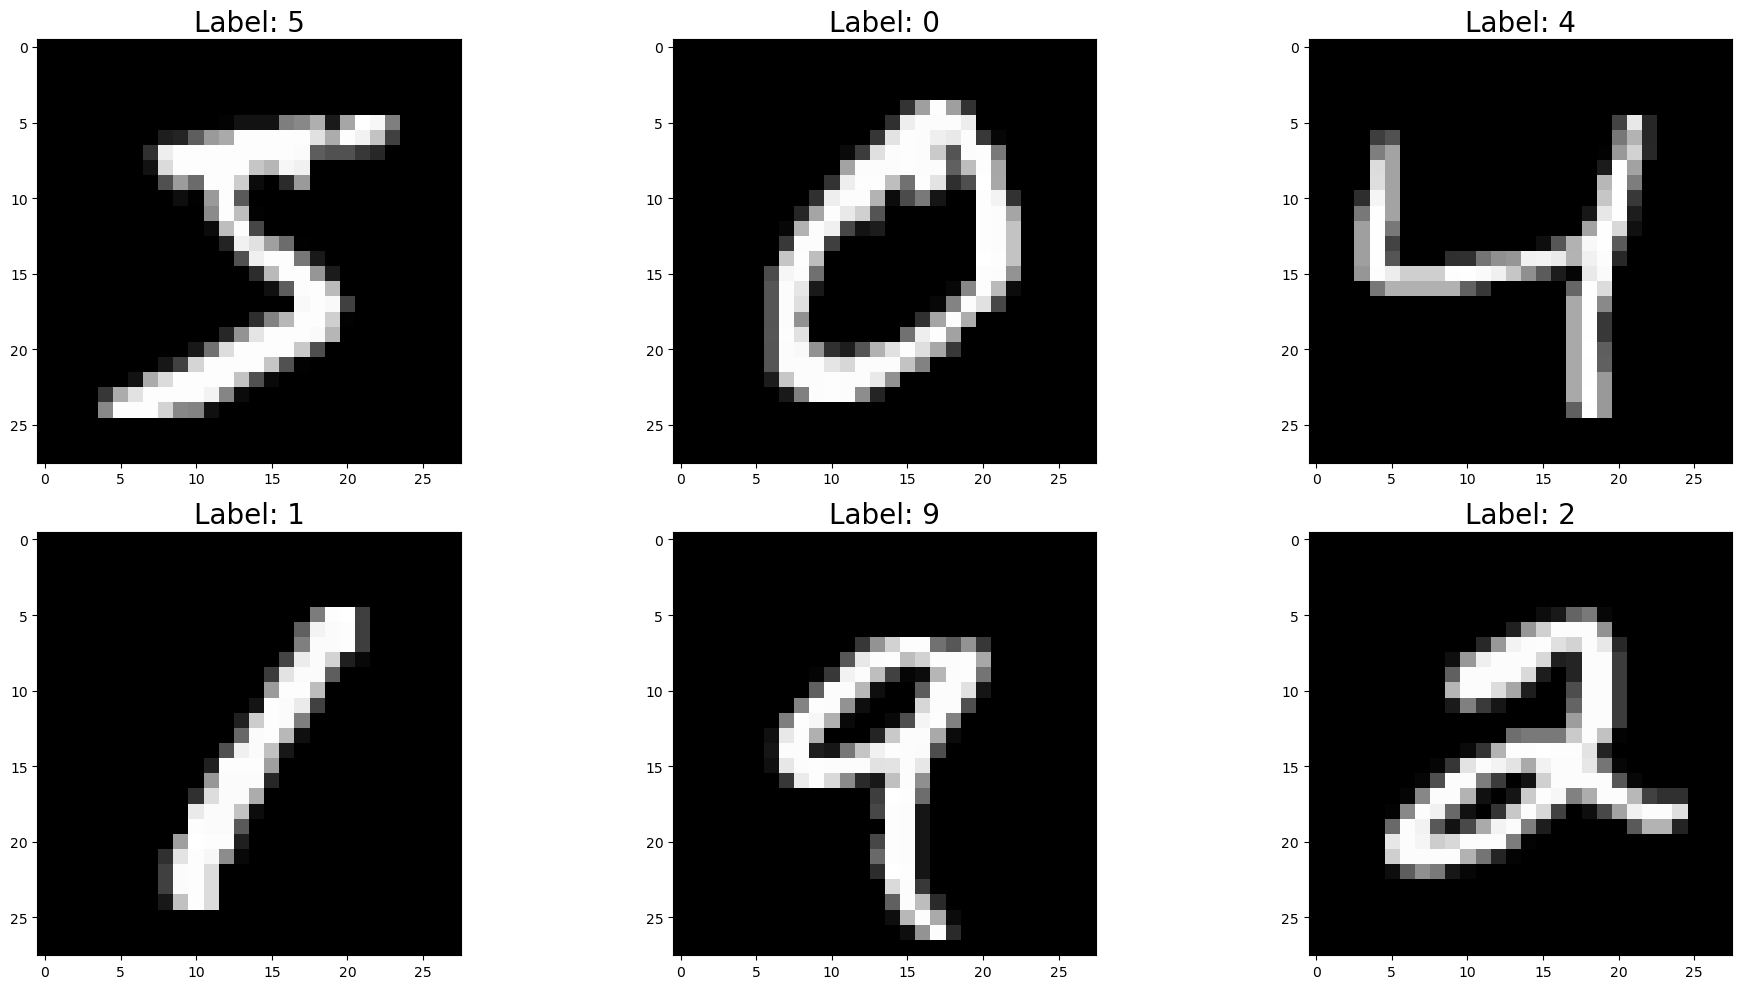

In [ ]:
current_image = np.array(data_train.iloc[0:6])

show_image_list(list_images=[x[1:].reshape((28,28)) for x in current_image], 
                list_titles=[f"Label: {x[0]}" for x in current_image],
                num_cols=3,
                figsize=(20, 10),
                grid=False,
                title_fontsize=20)

## **5. 데이터 관리 함수 만들기**

In [ ]:
from typing import Tuple

def normalize(X: np.ndarray, norm_value: int) -> np.ndarray:
    """numpy 행렬 정규화

    Args:
        X (np.ndarray): 입력 행렬
        norm_value (int): 정규화할 값

    Returns:
        np.ndarray: 정규화된 행렬
    """
    
    X = X/norm_value
    
    return X

def one_hot_encode(y: np.ndarray) -> np.ndarray:
    """원핫 인코딩이 적용된 Y값

    Args:
        y (np.ndarray): 입력 행렬

    Returns:
        np.ndarray: 원핫 인코딩이 적용된 Y값
    """
    encoded_y = np.zeros((y.shape[0], int(y.max()) + 1))
    for i in range(y.shape[0]):
        encoded_y[i][int(y[i][0])] = 1
        
    return encoded_y


def load_data(url: str) -> Tuple[np.ndarray, np.ndarray]:
    """파일에서 데이터 로드 및 사용 준비

    Args:
        url (str):파일 경로

    Returns:
        Tuple[np.ndarray, np.ndarray]: 준비된 데이터 -> X, y
    """
    
    data = np.array(pd.read_csv(url))
    X = normalize(data[:, 1:], 255)
    y = one_hot_encode(data[:,:1])
    
    return X, y

## **6. 학습 데이터, 평가 데이터 각각 읽어오기**

In [ ]:
X_train, y_train = load_data(DATA_PATH+"mnist_train.csv")
X_test, y_test = load_data(DATA_PATH+"mnist_test.csv")

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

y_train[0:6]

X_train: (60000, 784), y_train: (60000, 10)
X_test: (10000, 784), y_test: (10000, 10)


array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

>원핫 인코딩은 이전에 검색한 데이터와 일치 -> 값이 1인 인덱스는 레이블 값과 같음

## **7. 신경망 모델 정의**

In [ ]:
class DeepNeuralNet:
  
    def __init__(self, X: np.ndarray, y: np.ndarray, batch: int=64, learn: float = 0.005, epochs: int=50, l1_size: int=256, l2_size: int=128) -> None:
      """DeepNeuralNet 생성자

      Args:
          X (np.ndarray): 입력 행렬
          y (np.ndarray): 결과 데이터 행렬
          batch (int, optional): 확률적 경사 하강법에 대한 배치 크기다. 기본값은 64.
          learn (float, optional): 학습률. 기본값은 0.005
          epochs (int, optional): 신경망을 훈련할 주기의 수. 기본값은 50
          l1_size (int, optional): 첫 번째 레이어의 크기. 기본값은 256
          l2_size (int, optional): 두 번째 레이어의 크기. 기본값은 128
      """
      
      # init local variables from constructor
      self.input = X
      self.target = y
      self.batch = batch
      self.learn = learn
      self.epochs = epochs
      
      ## init local variables not included in contructor
      
      # batch input values
      self.x = self.input[:self.batch] 
      # batch target values
      self.y = self.target[:self.batch]
      
      self.loss = []
      self.accuracy = []
      
      # call method to init  weights
      self._init_weights(l1_size, l2_size)
      
    def _init_weights(self, l1_size: int, l2_size: int) -> None:
      """가중치 행렬 및 편향 행렬을 초기화하는 지원 함수

      Args:
          l1_size (int): 가중치 및 편향의 첫 번째 레이어 크기.
          l2_size (int): 가중치 및 편향의 두 번째 레이어 크기.
      """
      # init weights
      self.W1 = np.random.randn(self.input.shape[1], l1_size)
      self.W2 = np.random.randn(l1_size, l2_size)
      self.W3 = np.random.randn(l2_size, self.y.shape[1])
      
      #init biases
      self.b1 = np.random.randn(l1_size, )
      self.b2 = np.random.randn(l2_size, )
      self.b3 = np.random.randn(self.W3.shape[1], )
    
    def _ReLU(self, Z: np.ndarray) -> np.ndarray:
      """ReLU 활성화 함수

      Args:
          Z (np.ndarray): W @ X +b 이후의 결과 행렬 (@:행렬곱)

      Returns:
          A (np.ndarray): x < 0 : == 0 && x > 0: == x 인 행렬
      """
      A = np.maximum(0, Z)
      return A
      
    def _d_ReLU(self, Z: np.ndarray) -> np.ndarray:
      """ReLU 함수의 미분(도함수)

      Args:
          Z (np.ndarray): W @ X +b 이후의 결과 행렬

      Returns:
          np.ndarray: ReLU의 도함수
      """
      dReLU = 1 * (Z > 0)
      return dReLU
    
    def _softmax(self, Z: np.ndarray) -> np.ndarray:
      """Softmax 함수

      Args:
          Z (np.ndarray): W @ X +b 이후의 결과 행렬

      Returns:
          np.ndarray: softmax함수가 적용된 행렬
      """
      Z = Z - np.max(Z, axis=1).reshape(Z.shape[0], 1)
        
      A = np.exp(Z)/ np.sum(np.exp(Z), axis=1).reshape(Z.shape[0], 1)
      
      return A
    
    def _forward_prop(self) -> None:
      """네트워크를 통한 순방향 전파"""
      
      # enssure dimentions of matrices in the first layer are the correct size
      assert self.x.shape[1] == self.W1.shape[0]
      
      #propagate through first layer
      self.Z1 = self.x @ self.W1 + self.b1
      self.A1 = self._ReLU(self.Z1)
      
      # enssure dimentions of matrices in the second layer are the correct size
      assert self.A1.shape[1] == self.W2.shape[0]
      #propagate through second layer
      self.Z2 = self.A1 @ self.W2 + self.b2
      self.A2 = self._ReLU(self.Z2)
      
      # enssure dimentions of matrices in the third layer are the correct size
      assert self.A2.shape[1] == self.W3.shape[0]
      #propagate through third layer
      self.Z3 = self.A2 @ self.W3 + self.b3
      self.A3 = self._softmax(self.Z3)
      
      # update error
      self.error = self.A3 - self.y
      
    def _back_prop(self) -> None:
      """네트워크를 통한 역방향 전파"""
      
      d_cost = (1/self.batch) * self.error
      
      
      # precalculate common terms
      a = (d_cost @ self.W3.T)*self._d_ReLU(self.Z2)
      b = (a @ self.W2.T)* self._d_ReLU(self.Z1)

      # get derivitives of weights
      d_W3 = (d_cost.T @ self.A2).T
      d_W2 = (a.T @ self.A1).T
      d_W1 = (b.T @ self.x).T
      
      # get derivitives of biases
      d_b3 = np.sum(d_cost,axis = 0)
      d_b2 = np.sum(a,axis = 0)
      d_b1 = np.sum(b,axis = 0)
      
      
      # check if weight shapes match
      assert d_W3.shape == self.W3.shape
      assert d_W2.shape == self.W2.shape
      assert d_W1.shape == self.W1.shape
      
      # check if bias shapes match
      assert d_b3.shape == self.b3.shape
      assert d_b2.shape == self.b2.shape
      assert d_b1.shape == self.b1.shape
      
      # update weights
      self._update(d_W1, d_W2, d_W3, d_b1, d_b2, d_b3)
      
    def _update(self, d_W1: np.ndarray, d_W2: np.ndarray, d_W3: np.ndarray, d_b1: np.ndarray, d_b2: np.ndarray, d_b3: np.ndarray) -> None:
      """가중치 및 편향 업데이트

      Args:
          d_W1 (np.ndarray): W1의 도함수
          d_W2 (np.ndarray): W2의 도함수
          d_W3 (np.ndarray): W3의 도함수
          d_b1 (np.ndarray): b1의 도함수
          d_b2 (np.ndarray): b2의 도함수
          d_b3 (np.ndarray): b3의 도함수
      """      
      # update weights
      self.W1 -= self.learn * d_W1
      self.W2 -= self.learn * d_W2
      self.W3 -= self.learn * d_W3
      
      #update biases
      self.b1 -= self.learn * d_b1
      self.b2 -= self.learn * d_b2
      self.b3 -= self.learn * d_b3
      
    def _shuffle(self) -> None:
      idx = [i for i in range(self.input.shape[0])]
      np.random.shuffle(idx)
      self.input = self.input[idx]
      self.target = self.target[idx]
      
    def train(self) -> None:
      """모델 학습 함수"""
      for epoch in range(self.epochs):
        l = 0
        accuracy = 0
        self._shuffle()
        
        for batch in range(self.input.shape[0]//self.batch - 1):
          print(f"Epoch: {epoch}/{self.epochs} | Batch: {batch}/{self.input.shape[0]//self.batch - 1} | Accuracy: {self.accuracy[-1] if len(self.accuracy) > 0 else None} | Loss: {self.loss[-1] if len(self.loss) > 0 else None}", end="\r")
          # set start and end of batch
          s = self.batch*batch
          e = self.batch*(batch+1)
          
          # set x and y
          self.x = self.input[s:e]
          self.y = self.target[s:e]
          
          # forward / back prop and update
          self._forward_prop()
          self._back_prop()
          
          # get loss and accuracy
          l += np.mean(self.error**2)
          accuracy += np.count_nonzero(np.argmax(self.y, axis=1) == np.argmax(self.A3, axis=1))/self.batch
          
        #update loss and accuracy
        self.loss.append(l/(self.input.shape[0]//self.batch))
        self.accuracy.append(accuracy/(self.input.shape[0]//self.batch))
        
    def test(self, X_test, y_test) -> None:
      """모델 평가 함수

      Args:
          X_test (np.ndarray): 입력 데이터
          y_test (np.ndarray): 결과 데이터
      """
      
      # set x and y
      self.x = X_test
      self.y = y_test
      
      # forward prop through network
      self._forward_prop()
      
      # get accuracy
      accuracy = np.count_nonzero(np.argmax(self.y, axis=1) == np.argmax(self.A3, axis=1))/self.x.shape[0]
      
      # print accuracy
      print(f"Test accuracy: {accuracy*100}%")
      
    def predict(self, X: np.ndarray) -> np.ndarray:
      """네트워크를 사용하여 예측

      Args:
          X (np.ndarray): 입력 값

      Returns:
          np.ndarray: 예측 값
      """
      # set self.x with given input values
      self.x = X
      
      # propagate forward through the network
      self._forward_prop()
      
      # return predicted value
      return np.argmax(self.A3, axis=1)[0] 
      
    def plot_loss_and_accuracy(self) -> None:
      """정확도, 손실값 쌍으로 그래프 그리기"""
      # set up subplots
      plt.figure(1,figsize=(30,8))
      
      # plot loss
      plt.subplot(121)
      plt.plot(self.loss)
      plt.xlabel("Epochs")
      plt.ylabel("Loss")
      plt.title(f"Loss: {self.loss[-1]}")
      
      # plot accuracy
      plt.subplot(122)
      plt.plot(self.accuracy)
      plt.xlabel("Epochs")
      plt.ylabel("Accuracy")
      plt.title(f"Accuracy: {self.accuracy[-1]*100}%")
      
      # show plots
      plt.show()
      
    def plot_loss(self) -> None:
      """plot loss"""
      # feed loss array to pyplot
      plt.plot(self.loss)
      
      # set x and y labels
      plt.xlabel("Epochs")
      plt.ylabel("Loss")
      
      # display plot
      plt.show()
      
    def plot_accuracy(self) -> None:
      """plot accuracy"""
      # feed accuracy array to pyplot
      plt.plot(self.accuracy)
      
      # set x and y labels
      plt.xlabel("Epochs")
      plt.ylabel("Accuracy")
      
      # display plot
      plt.show()
      

## **8. 모델 학습 및 평가**

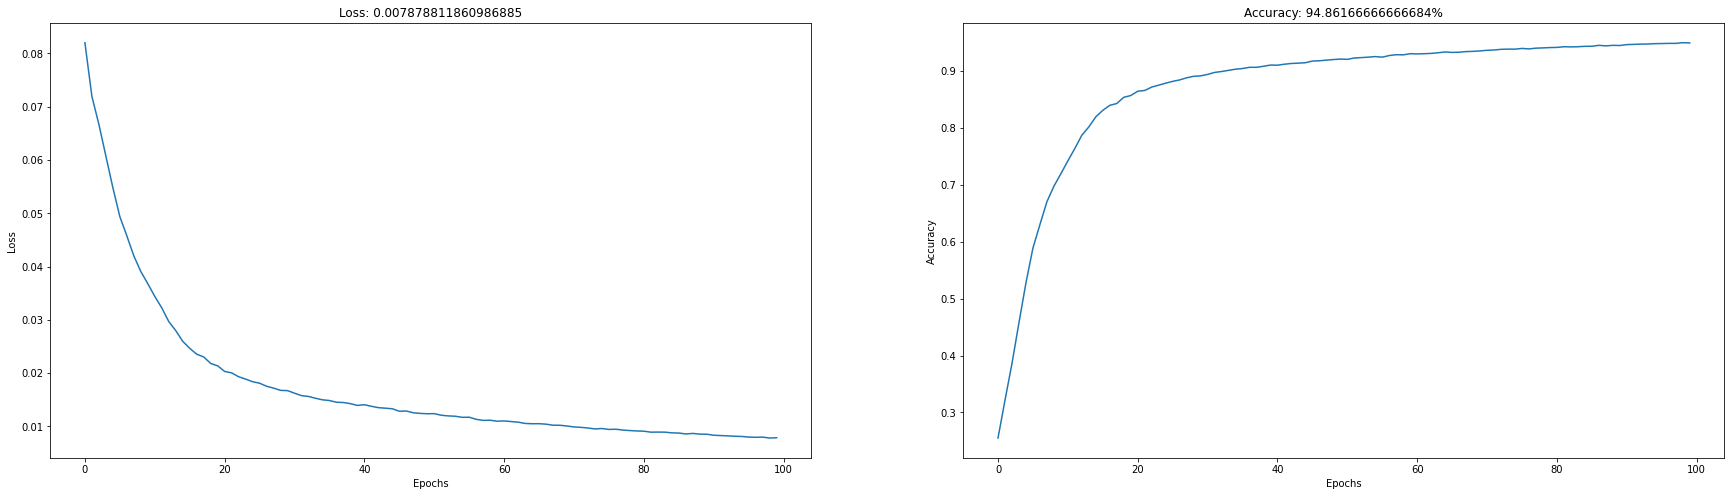

Test accuracy: 93.24%


In [ ]:
net = DeepNeuralNet(X_train, y_train, batch=100, learn=0.05, l2_size=128, epochs=100)
net.train()
net.plot_loss_and_accuracy()
net.test(X_test, y_test)

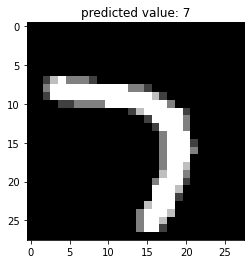

In [ ]:
X = X_test[60, :].reshape(1, 784)
X.shape

pred_val = net.predict(X)

plt.imshow(X.reshape((28,28)), cmap="gray")
plt.title(f"predicted value: {pred_val}")
plt.grid(visible=False)